In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()

# Lifting bodies

This section will modify the vortex panel method to enable the prediction of lift on wing sections.

## Foil section geometry

To find the lift on a foil, we first need to define the geometry. Let's use a symmetric Jukowski foil for now. This foil shape is obtained by applying the following mapping

$$ x' = \frac x2 (1+1/r^2), \quad y' = \frac y2 (1-1/r^2),\quad r^2= x^2+y^2 $$

to the points on a circle which intersects $x,y=1,0$. Shifting the center of the circle an amount $\Delta x$ sets the thickness of the foil. I've followed this procedure in the function `VortexPanel.make_jukowski`. Let's import that module as `vp` again:

In [16]:
import numpy
from matplotlib import pyplot
%matplotlib notebook
import VortexPanel as vp
help(vp.make_jukowski)

Help on function make_jukowski in module VortexPanel:

make_jukowski(N, dx=0.18, dtheta=0, dr=0)
    Make a foil-shaped PanelArray using the Jukowski mapping
    
    Note:
    Foil-shapes are obtained adjusting a circle and then mapping
    
    Inputs:
    N         -- number of panels to use
    dx        -- negative extent beyond x = -1
    dtheta    -- angle of rotation around (1,0)
    dr        -- radius extent beyond r = 1
    
    Outputs:
    A PanelArray object; see help(PanelArray)
    
    Examples:
    foil = vp.make_jukowski(N=64)    # make a symmetric foil Panel array
    foil.plot()                      # plot the geometry



The arguments are a number of points $N$, the x-shift `dx`$=\Delta x$, and similar shifts to the angle `dtheta`$=\Delta \theta$ and radius `dr`$=\Delta r$. Let's test it out.

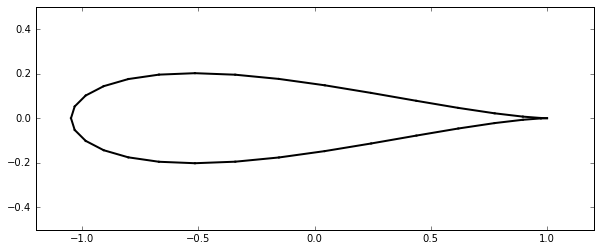

In [3]:
pyplot.figure(figsize=(10,4))
pyplot.axis([-1.2,1.2,-.5,.5])

foil = vp.make_jukowski(N=32)
foil.plot()

##### Quiz

How can you get a cambered (ie, curved) foil shape using the Jukowski transform?

1. Shift the center right or left.
1. **Rotate the circle around (1,0).**
1. Change the circle's radius.
---

## Flows with circulation

Now lets solve for the flow around the foil:

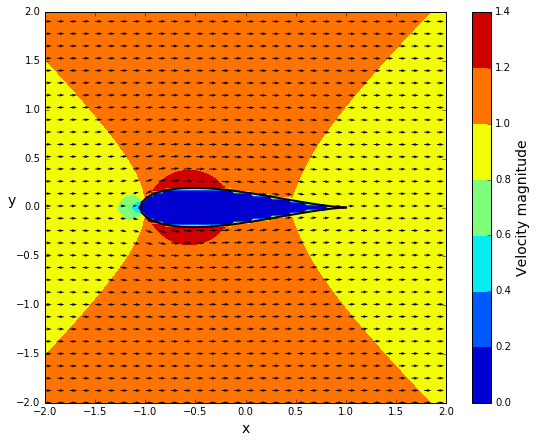

In [4]:
foil = vp.make_jukowski(N=32) # make the geom
foil.solve_gamma()            # solve for gamma
foil.plot_flow()              # plot the flow

Whoops. We need an angle of attack.

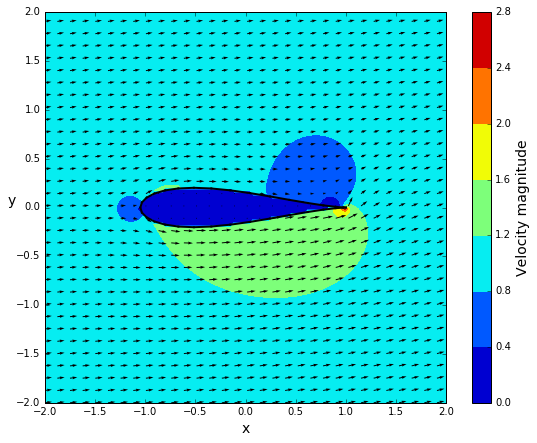

In [5]:
alpha = numpy.pi/16         # set angle of attack
foil.solve_gamma(alpha)     # solve for gamma
foil.plot_flow()            # plot the flow

Sigh. There are so many things wrong with this picture...

 - The flow is faster on the underside of the foil. 
 - The rear stagnation point is on the upper side of the foil.
 - There is a singularity on the lower side of the trailing edge.

These are all physically incorrect! But how can setting the (physical) no-slip condition on each panel lead to non-physical results?

##### Mathematics fundamental: Necessary but insufficient
##### The no-slip condition is not sufficient to uniquely determine the flow around lifting bodies

This means there are many (non-physical) solutions for this flow, one of which is given above. __If__ there is a unique physical solution, we will need an additional condition to determine it.

## The Kutta condition

There **is** a unique physical solution for this flow, and this is because the foil has a sharp trailing edge.

##### Quiz

What does the flow need to look like on the trailing edge?

![short](resources\trailingEdge.png)

1. The flow needs to wrap from the bottom to the top.
1. The flow needs to wrap from the top to the bottom.
1. **The flow needs to separate from the edge.**

---
The fundamental problem with the solution for the foil above is that the flow is wrapping around the sharp trailing edge. This means that particles traveling on the body streamline *instantly* change direction - which is impossible for any object with mass.

Avoiding this impossibility is called the Kutta condition.

##### Hydrodynamics fundamental: Kutta condition
##### "Potential flow must separate from a sharp trailing edge"

This uniquely determines the correct solution $\gamma_i$ and it links the solution to the angle of attack $\alpha$ to the lift. As $\alpha$ is increased, the amount of circulation increases to enforce the Kutta condition.

To enforce the Kutta condition in the vortex panel method, we need to convert it into a statement about the strength $\gamma(s)$. 

##### Quiz

What condition on $\gamma(s)$ will enforce the Kutta conditions?

1. $\gamma=U_\infty$ near the trailing edge
1. $\gamma=0$ near the trailing edge
1. **$\gamma$ is antisymmetric about the trailing edge, ie $\gamma(\epsilon)+\gamma(-\epsilon)=0$**

(Hint: Look at the sketch above. What does it tell you about $\gamma$ near the trailing edge?)

---

This condition has already been added to the solver. You may have noticed that the `solve_gamma` function takes an optional `kutta` argument. This lets you define any number trailing edges (by a list of index pairs) and enforce the kutta condition on them all:

In [6]:
help(foil.solve_gamma)

Help on method solve_gamma in module VortexPanel:

solve_gamma(alpha=0, kutta=[]) method of VortexPanel.PanelArray instance
    Set the vortex strength on a PanelArray to enforce the no slip and
    kutta conditions.
    
    Notes:
    Solves for the normalized gamma by using a unit magnitude background
    flow, |U|=1.
    
    Inputs:
    alpha   -- angle of attack relative to x-axis; must be a scalar; default 0
    kutta   -- panel indices (a list of tuples) on which to enforce the kutta
                condition; defaults to empty list
    
    Outputs:
    gamma of the PanelArray is updated.
    
    Examples:
    foil = vp.make_jukowski(N=32)                    # make a Panel array
    foil.solve_gamma(alpha=0.1, kutta=[(0,-1)])      # solve for gamma
    foil.plot_flow()                                 # plot the flow



As in the example above and in the docstring, the two panels on either side of the trailing edge are `(0,N-1)` for the jukowski foil, so we can use
```python
foil.solve_gamma(alpha,kutta=[(0,-1)])
```
Lets, try it out!

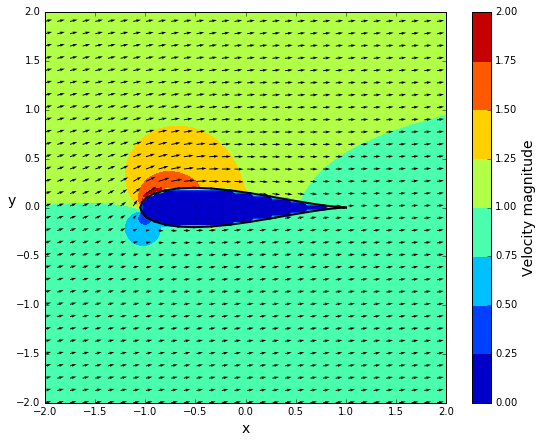

In [7]:
foil = vp.make_jukowski(N=32)            # make the geom
alpha = numpy.pi/16                      # set angle of attack
foil.solve_gamma(alpha,kutta=[(0,-1)])   # solve
foil.plot_flow()                         # plot

The flow plot shows the correct qualitative features:
- High speed flow on the top.
- Slow flow on the trailing edge.

To test if this function really does apply the kutta condition, let's plot $\gamma$ versus $s$, like in the last notebook:

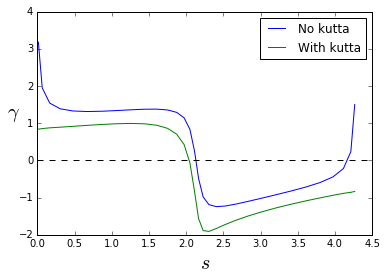

In [8]:
alpha = numpy.pi/16                     # angle of attack
foil = vp.make_jukowski(N=32)           # make geometry
s = foil.distance()                     # distance array

# solve without kutta and plot 
foil.solve_gamma(alpha)                 # solve
gamma = foil.get_array('gamma')         # get
pyplot.plot(s,gamma,label="No kutta")   # plot

# solve with kutta and plot
foil.solve_gamma(alpha,kutta=[(0,-1)])  # solve
gamma = foil.get_array('gamma')         # get
pyplot.plot(s,gamma,label="With kutta") # plot

# finish gamma(s) plot
pyplot.legend()
pyplot.xlabel(r'$s$', fontsize=20)
pyplot.ylabel(r'$\gamma$', fontsize=20, rotation=0)
pyplot.axhline(0,c='k',ls='--')
pyplot.show()

The quantitative comparison shows that $\gamma(0)=-\gamma(-1)$ meaning that the Kutta condition has been successfully enforced. 

Note that this has completely changed the solution on the foil and will lead to a different lift force.

## Lift force

Speaking of lift, the Kutta-Joukowski lift force on a body in potential flow is

$$ L = -\rho U \Gamma = -\rho U^2 \tilde\Gamma $$

where $\tilde\Gamma=\oint\tilde\gamma(s)ds$. Note that since we solve with $|U|=1$ our $\gamma = \tilde\gamma$.

We non-dimensionalize the lift as the lift coefficient

$$ C_L =\frac L{\tfrac 12 \rho U^2 c} $$

where $c$ is the coord length, the distance from the leading to trailing edge. Note that the vortex panel


---

##### Quiz

What is the expression for the lift coefficient in terms `gamma` and the panel half-width `S`?
- `-sum(gamma)/(0.5*rho*c*U)`
- `-sum(gamma*2*S)/(0.5*c)`
- `-sum(gamma)*2*S/0.5*c*U`
---


## Numerical validation

Before we implement that, how will we know if our lift predictions are any good?

##### Numerical fundamental: Validation
##### A method is validated by comparing the result to a known solution

The reason I implemented a Jukowski foil is not because it is a great foil shape (it isn't). It is because there is an analytic solution!

$$C_L = 2\pi \left(1+\frac 4{3\sqrt 3} \frac tc \right)\sin\alpha$$

where $t/c$ is the thickness to coord ratio. You'll use this to test the predictions:

##### Your turn #3

 - ** Complete ** the function `C_L` to compute $C_L$ given a panel array. 
 - ** Complete ** the function `solver_C_L` to compute $C_L$ for a Jukowski foil given an angle of attack. 
 - ** Plot and Compare ** the numerical C_L for $\alpha=0,\ldots,15^o$ against the analytic solution.
 - ** Discuss ** the results. Do they indicate the point of *stall*? Why or why not?

In [9]:
def C_L(panels):
    # panel attribute arrays
    gamma, xc, S = panels.get_array('gamma','xc','S')

    # chord length
    c = max(xc) - min(xc)
    
    # return the lift coefficient
    return -sum(gamma * 2 * S) / (0.5 * c)

In [19]:
def solver_C_L(alpha, N=80):
    foil = vp.make_jukowski(N=N)
    foil.solve_gamma(alpha, kutta=[(0, -1)])
    return C_L(foil)

<IPython.core.display.Javascript object>


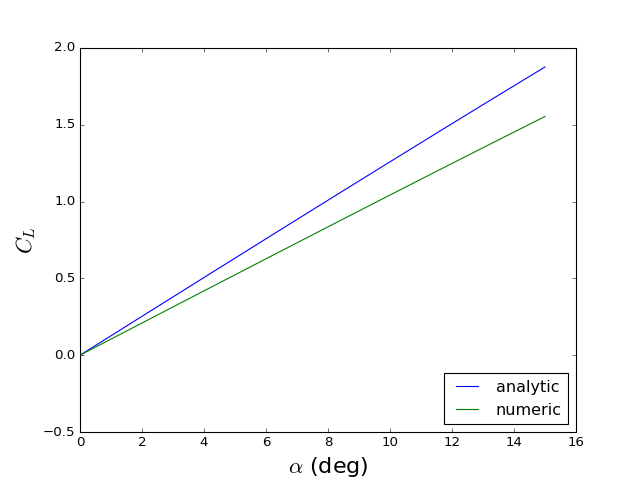

In [29]:
def analytic_C_L(alpha,t_c=0.2):
    return 2*numpy.pi*(1+t_c*4/(3*numpy.sqrt(3)))*numpy.sin(alpha)

alpha_deg = numpy.linspace(0,15,15)
alpha = alpha_deg*numpy.pi/180.
pyplot.plot(alpha_deg,analytic_C_L(alpha), label='analytic')
pyplot.plot(alpha_deg,[solver_C_L(a) for a in alpha], label='numeric')

pyplot.legend(loc='lower right')
pyplot.xlabel(r'$\alpha$ (deg)', fontsize=20)
pyplot.ylabel(r'$C_L$', fontsize=20)

In [27]:
alpha = numpy.math.radians(-14)      # set angle of attack
foil = vp.make_jukowski(N=128)
foil.solve_gamma(alpha, kutta=[(0, -1)])     # solve for gamma
gamma = foil.get_array('gamma')
abs(gamma[-1])

0.82550798097018963

In [28]:
alpha = numpy.math.radians(10)
100 * -(analytic_C_L(alpha) - solver_C_L(alpha,102))/analytic_C_L(alpha)

-14.927751796092259